# Indentifying Stress Factors in Rainbow Trouts - ML

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

# https://pmc.ncbi.nlm.nih.gov/articles/PMC11789298/

%autosave 30

Autosaving every 30 seconds


In [2]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.utils import shuffle

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb


SEED = 32

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Common Features

In [4]:
commonFeatures = []
with open("./primaryColumnList.txt", "r") as f:
  for line in f:
    commonFeatures.append(str(line.strip()))

In [5]:
observedFeatures = []
with open("./experimentalColumnList.txt", "r") as f:
  for line in f:
    observedFeatures.append(str(line.strip()))

In [6]:
len(observedFeatures)

234

## USDA Data

In [7]:
%%time
dataPath = './data/TPM_stress_USDA.xlsx'
columns = ['GeneExp']+[f"con{i}" for i in range(0,10)]+[f"cro{i}" for i in range(0, 6)]+[f"hs{i}" for i in range(0, 6)]+[f"ht{i}" for i in range(0, 6)]+[f"lt{i}" for i in range(0, 6)]+[f"rw{i}" for i in range(0, 6)]

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]

colDefMap = {'con':"Control", 'cro':"Crowded", "hs": "High Salinity", "ht": "High Temp", "lt": "Low Temp", 'rw': "Reu"}

# data = pd.read_excel(dataPath, nrows = 1000)
dataUSDA = pd.read_excel(dataPath)

dataUSDA.columns = columns
dataUSDA = dataUSDA.set_index('GeneExp').T

tankColums = [f"con" for i in range(0,10)]+[f"cro" for i in range(0, 6)]+[f"hs" for i in range(0, 6)]+[f"ht" for i in range(0, 6)]+[f"lt" for i in range(0, 6)]+[f"rw" for i in range(0, 6)]
dataUSDA = dataUSDA.assign(tank = tankColums)

print(dataUSDA.shape)
dataUSDA.head()

(40, 125909)
CPU times: user 21 s, sys: 264 ms, total: 21.2 s
Wall time: 21.3 s


GeneExp,4ebp2_1,5ntc_1,aacs_1,aadac_1,aadacl4_1,aagab_1,aakb1_1,aakb1_2,aakb1_3,aakb1_4,...,zwilch_2,zwilch_3,zwilch_4,zyg11_1,zyx_1,zyx_2,zzef1_1,zzef1_2,zzef1_3,tank
con0,25.225544,28.080450,2.732412,2.577981,1.763941,2.941886,57.036954,0.0,0.0,0.0,...,0.315159,0.506264,0.648684,20.875030,6.120552,16.849759,0.939789,0.999776,1.047765,con
con1,26.183206,27.814776,2.627333,2.488354,1.151104,3.088248,50.187026,0.0,0.0,0.0,...,0.537108,0.450512,0.495588,20.891255,6.146838,17.194558,0.937600,0.880660,1.040090,con
con2,24.462669,30.805397,2.260763,2.257356,1.382630,3.376831,51.169195,0.0,0.0,0.0,...,0.335363,0.551145,0.793690,19.433228,10.574061,13.420285,0.886052,0.829211,0.852616,con
con3,25.182863,29.473753,2.413444,2.288551,1.275375,3.316769,52.491676,0.0,0.0,0.0,...,0.550434,0.514201,0.492439,19.485679,6.131069,17.384730,0.945092,0.839348,0.902134,con
con4,26.305005,18.204322,2.807522,2.990708,0.949599,3.221152,47.154350,0.0,0.0,0.0,...,0.477111,0.442123,0.387635,19.494654,6.341428,17.291068,0.748626,0.799147,0.698106,con


## UMD Data

In [8]:
%%time
dataPath = './data/TPM_stress_RedTrout.xlsx'

# data = pd.read_excel(dataPath, nrows = 100)
dataUMD = pd.read_excel(dataPath)

colsTemp = ['idx']+['CTRL']*(dataUMD.shape[1]//2)+['HEAT']*(dataUMD.shape[1]//2)

dataUMD.columns = colsTemp
dataUMD.iloc[0,0] = 'DAY'

dataUMD = dataUMD.set_index("idx").T.reset_index(drop=False, names = 'GeneExp')#.set_index("DAY", append=True)
dataUMD.rename(columns={'GeneExp':'Group'}, inplace=True)
print(dataUMD.shape)

(72, 125910)
CPU times: user 38.4 s, sys: 434 ms, total: 38.8 s
Wall time: 38.9 s


## Primary Features

In [10]:
%%time
umdDataFeatures = dataUMD.columns.tolist()

commonFeaturesUMD = list(set(umdDataFeatures) & set(commonFeatures))

print(f"{len(commonFeatures)*100/len(umdDataFeatures):.2f}% of UMD data feature set")
print(f"{len(commonFeaturesUMD)*100/len(commonFeatures):.2f}% of the training data feature set (USDA)")

54.86% of UMD data feature set
71.48% of the training data feature set (USDA)
CPU times: user 29 ms, sys: 2.46 ms, total: 31.4 ms
Wall time: 31.6 ms


## Merging UMD & USDA data

In [11]:
dataModelUSDA = dataUSDA.loc[:,commonFeaturesUMD+['tank']].copy().reset_index(drop=True)
dataModelUSDA = dataModelUSDA[(dataModelUSDA['tank'] == 'con') | (dataModelUSDA['tank'] == 'ht')]
dataModelUSDA.loc[:,:] = dataModelUSDA.replace({'tank':{'con':0, 'cro':3, "hs": 2, "ht": 1, "lt": 4, 'rw': 5}})

dataModelUSDA = dataModelUSDA.assign(src='usda')
dataModelUSDA.head()

GeneExp,nmd3_3,LOC110537252_4,LOC110533979_4,LOC110527982_4,LOC110533412_7,LOC110507857_1,LOC110500297_2,LOC110501467_1,LOC110524331_2,naa35_2,...,ppargc1a_1,dffb_2,LOC118966024_3,LOC110498401_1,LOC110532499_3,if5_2,LOC110499994_2,LOC110510413_1,tank,src
0,2.618025,0.455069,1.611796,0.388763,0.397213,0.010527,0.095078,47.023726,0.103655,2.975531,...,0.080076,2.451952,0.336001,0.046897,0.014228,6.986061,5.915124,2.691329,0,usda
1,2.043900,0.376415,1.234566,0.287487,0.447537,0.069945,0.157934,43.153269,0.098390,3.157587,...,0.084950,1.962312,0.327325,0.050874,0.027010,8.348170,6.119233,3.661607,0,usda
2,3.095533,0.429394,1.305974,0.249448,0.386104,0.088013,0.158987,46.330694,0.081248,3.494097,...,0.082703,2.050041,0.362246,0.061616,0.035687,9.282925,5.813311,3.750300,0,usda
3,2.598536,0.459294,1.347278,0.197974,0.418951,0.073937,0.265155,43.102125,0.074945,3.867658,...,0.108982,2.026084,0.248417,0.030448,0.000000,8.117840,5.354916,4.299511,0,usda
4,2.384003,0.317309,1.515169,0.301113,0.341209,0.060448,0.204737,30.251621,0.148805,2.706939,...,0.086554,4.969345,0.213251,0.000000,0.016340,9.849903,3.449933,5.615092,0,usda


In [13]:
dataModelUMD = dataUMD.loc[:, commonFeaturesUMD+['Group']]
dataModelUMD.rename(columns={'Group':'tank'},inplace=True)
dataModelUMD.loc[:,:] = dataModelUMD.replace({'tank':{'CTRL':0, "HEAT": 1}})

dataModelUMD = dataModelUMD.assign(src='umd')
dataModelUMD.head()

idx,nmd3_3,LOC110537252_4,LOC110533979_4,LOC110527982_4,LOC110533412_7,LOC110507857_1,LOC110500297_2,LOC110501467_1,LOC110524331_2,naa35_2,...,ppargc1a_1,dffb_2,LOC118966024_3,LOC110498401_1,LOC110532499_3,if5_2,LOC110499994_2,LOC110510413_1,tank,src
0,1.512286,0.348428,0.309714,0.138447,0.191627,0.624649,0.045499,56.272183,0.136408,2.239851,...,0.063114,4.785438,0,0.179537,0.054469,9.551706,4.296394,5.666776,0,umd
1,1.523516,0.380303,0.738653,0,0.323074,0.562264,0.040304,36.614132,0.175762,2.097529,...,0.087857,5.543482,0.389818,0,0.024125,9.042998,6.223963,7.757961,0,umd
2,1.416989,0.346877,0.406595,0.03938,0.323524,0.286575,0.051767,76.489661,0.084655,1.60187,...,0.112843,1.361179,0.038514,0,0.061973,11.207237,4.428872,5.079829,0,umd
3,1.299282,0.473506,0.586046,0,0.327875,0.216854,0.122414,35.983873,0.276447,2.779484,...,0.090102,1.768574,0.312255,0.054219,0.041871,8.719253,5.388612,2.772082,0,umd
4,1.342292,0.336162,0.095669,0,0.225661,0.257457,0.265753,25.905487,0.126756,1.892333,...,0.098744,1.61258,0.061787,0.117038,0.099421,7.758407,3.714707,5.015031,0,umd


In [14]:
# dataModel = pd.concat([dataModelUMD, dataModelUSDA],axis=0).sample(frac=1)
dataModel = dataModelUMD.sample(frac=1)
dataModel = dataModel.assign(strat = dataModel[['tank', 'src']].apply(lambda row: f"{row['tank']}_{row['src']}", axis=1))
print(dataModel.shape)
dataModel.head()

(72, 49381)


idx,nmd3_3,LOC110537252_4,LOC110533979_4,LOC110527982_4,LOC110533412_7,LOC110507857_1,LOC110500297_2,LOC110501467_1,LOC110524331_2,naa35_2,...,dffb_2,LOC118966024_3,LOC110498401_1,LOC110532499_3,if5_2,LOC110499994_2,LOC110510413_1,tank,src,strat
62,0.838741,0.259986,0.061262,0.033375,0.139083,0,0.058498,13.765599,0.207268,1.398754,...,0.354961,0.021761,0,0.017508,18.497768,3.893723,0,1,umd,1_umd
33,1.110444,0.353817,0.536957,0.126015,0.29579,0.300436,0.157763,27.886692,0.146196,1.974923,...,5.297069,0.117374,0,0.472167,9.397795,3.774779,3.69167,0,umd,0_umd
35,4.721866,2.412723,0.158072,0.14034,0.601541,3.238375,6.238875,10.830128,7.459933,5.614282,...,2.849469,1.422441,0,0.281087,1.232297,5.191647,0,0,umd,0_umd
70,0.634906,0.280223,0.299029,0.070275,0.150611,0.111579,0.268742,21.233192,0.201428,1.299366,...,0.815357,0,0.265113,0.020108,17.895135,4.138089,4.627676,1,umd,1_umd
28,1.049517,0.355189,0.625617,0.009879,0.127037,0.103526,0.207788,45.91155,0.113267,1.936248,...,3.887624,0,0.256229,0,7.497522,5.052858,4.803439,0,umd,0_umd


In [15]:
dataModel['strat'].value_counts()

strat
1_umd    36
0_umd    36
Name: count, dtype: int64

# Models

In [16]:
def resultAnalysisFnx(ytrue,ypred,target_names=None):
    if target_names != None:
        print(classification_report(ytrue,ypred,target_names = target_names, zero_division=0))
    else:
        print(classification_report(ytrue,ypred, zero_division=0))

    conf_matrix = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(4, 2))
    if target_names != None:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, xticklabels=target_names,yticklabels=target_names, linewidths=0.8, linecolor='black')
    else:
        sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', cbar=False, linewidths=0.8, linecolor='black', xticklabels=True, yticklabels=True)

    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return classification_report(ytrue,ypred,output_dict=True, zero_division=0)

In [17]:
%%time
# xdata, ydata = dataModel.iloc[:,:-3], dataModel.iloc[:,-3]
# ydata = np.array(ydata.astype(int))

xdata, ydata = dataModel.iloc[:,:-3], dataModel.iloc[:,-3:-1]
ydata.iloc[:,0] = np.array(ydata.iloc[:,0].astype(int))

sca = StandardScaler()

xdata_sca = sca.fit_transform(xdata)

xstrain, xstest, ytrain, ytest = train_test_split(xdata_sca, ydata, test_size=0.3, stratify=dataModel['strat'], random_state=SEED)

CPU times: user 352 ms, sys: 15.8 ms, total: 368 ms
Wall time: 365 ms


## Mutual Information

In [18]:
%%time
# Mutual Information
mi = mutual_info_classif(xdata, ydata.iloc[:,0].astype(int), n_jobs=-1)

CPU times: user 1.6 s, sys: 165 ms, total: 1.77 s
Wall time: 5.97 s


In [19]:
featureScoresMI = pd.DataFrame({"feature":xdata.columns, "score":mi})
featureScoresMI.sort_values(by='score', ascending=False, inplace=True)

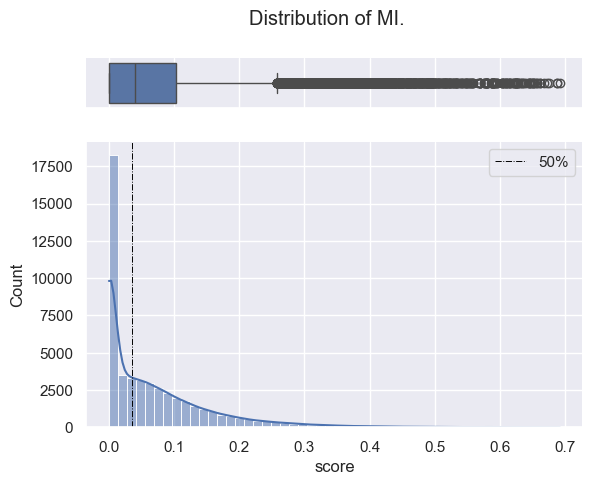

In [20]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(featureScoresMI['score'], ax=ax_box, orient='h')
sns.histplot(featureScoresMI['score'],bins=50, kde=True, ax=ax_hist)
ax_hist.axvline(0.035026,c='black',ls='-.', lw=0.7, label='50%')
plt.legend()

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
fig.suptitle("Distribution of MI.")
plt.show()

In [21]:
featureScoresMI.describe()

,score
count,49378.000000
mean,0.068925
std,0.087587
min,0.000000
25%,0.000000
50%,0.040014
75%,0.103299
max,0.692038


In [22]:
featureScoresMI[featureScoresMI['score']!=0]

,feature,score
44229,LOC110510214_4,6.920380e-01
14162,cysltr2b_2,6.874084e-01
16413,LOC110505605_1,6.869454e-01
36062,LOC110510214_2,6.748867e-01
31678,hsp47_1,6.718991e-01
...,...,...
20471,LOC110525412_2,1.552939e-05
5738,LOC110524287_4,1.107783e-05
46690,LOC110535019_3,7.763240e-06
31760,LOC110503415_3,1.056983e-06


## Logistic Regression

In [23]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xstrain, ytrain.iloc[:,0].astype(int))

CPU times: user 23.1 s, sys: 4.63 s, total: 27.7 s
Wall time: 3.69 s


LogisticRegression(random_state=32)

In [24]:
%%time
ypred = logRes_clf.predict(xstest)

CPU times: user 16 ms, sys: 28.3 ms, total: 44.2 ms
Wall time: 7.39 ms


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



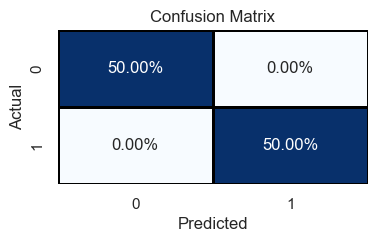

In [25]:
_ = resultAnalysisFnx(ytest.iloc[:,0].astype(int), ypred, target_names=None)

In [26]:
importances = logRes_clf.coef_[0]

49317


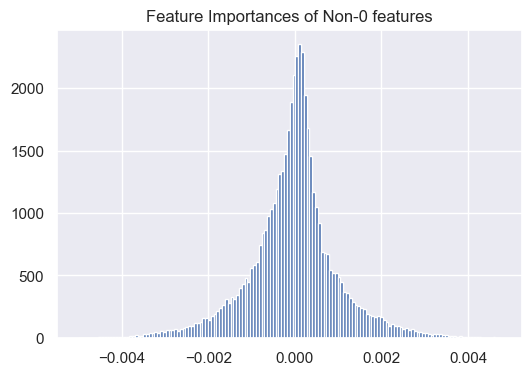

In [27]:
print(len(importances[importances!=0]))

plt.figure(figsize=(6,4), dpi = 100)
plt.hist(importances[importances!=0], bins = 150)
# plt.hist(importances, bins = 150)
plt.title("Feature Importances of Non-0 features")
plt.show()

## Decision Trees

In [28]:
%%time
dt_clf = DecisionTreeClassifier()

dt_clf.fit(xstrain, ytrain.iloc[:,0].astype(int))

CPU times: user 371 ms, sys: 4.06 ms, total: 375 ms
Wall time: 130 ms


DecisionTreeClassifier()

In [29]:
%%time
ypred = dt_clf.predict(xstest)

CPU times: user 3.52 ms, sys: 1.36 ms, total: 4.88 ms
Wall time: 1.3 ms


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



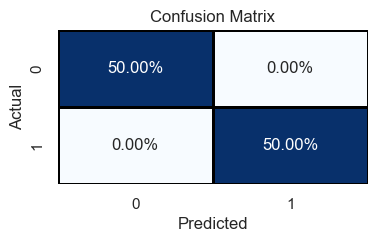

In [30]:
_ = resultAnalysisFnx(ytest.iloc[:,0].astype(int), ypred, target_names=None)

In [31]:
importance = dt_clf.feature_importances_
for i,j in zip(xdata.columns, importance):
    if j != 0:
        print(i, j)

LOC110522488_3 1.0


## Random Forest

In [32]:
rf_clf = RandomForestClassifier()
rf_clf.fit(xstrain, ytrain.iloc[:,0].astype(int))

RandomForestClassifier()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



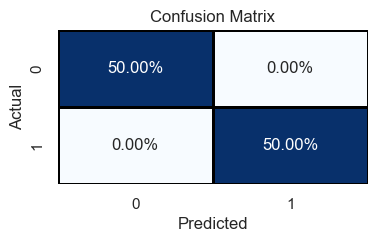

CPU times: user 115 ms, sys: 5.09 ms, total: 120 ms
Wall time: 39.3 ms


In [33]:
%%time
ypred = rf_clf.predict(xstest)

_ = resultAnalysisFnx(ytest.iloc[:,0].astype(int), ypred, target_names=None)

In [34]:
imp_dict = {'fea':[],'imp':[]}
importance = rf_clf.feature_importances_
for i,j in zip(xdata.columns, importance):
    if j != 0:
        # print(i, j)
        imp_dict['fea'].append(i)
        imp_dict['imp'].append(j)
imp_df = pd.DataFrame(imp_dict).sort_values('imp', ascending=False)

In [36]:
temp_ = list(set(observedFeaturesUMD) & set(imp_df['fea']))
print(len(temp_))

NameError: name 'observedFeaturesUMD' is not defined

In [ ]:
temp_

## Recursive Feature Elimination 

In [116]:
%%time
# logRes_clf = LogisticRegression(random_state=SEED, penalty='elasticnet',solver='saga',C=0.21, l1_ratio=0.5)
logRes_clf = LogisticRegression(random_state=SEED)
selector = RFE(logRes_clf, n_features_to_select=100, step=0.05, verbose = 0)

selector.fit(xstrain, ytrain.iloc[:,0].astype(int))

Fitting estimator with 49378 features.
Fitting estimator with 46910 features.
Fitting estimator with 44442 features.
Fitting estimator with 41974 features.
Fitting estimator with 39506 features.
Fitting estimator with 37038 features.
Fitting estimator with 34570 features.
Fitting estimator with 32102 features.
Fitting estimator with 29634 features.
Fitting estimator with 27166 features.
Fitting estimator with 24698 features.
Fitting estimator with 22230 features.
Fitting estimator with 19762 features.
Fitting estimator with 17294 features.
Fitting estimator with 14826 features.
Fitting estimator with 12358 features.
Fitting estimator with 9890 features.
Fitting estimator with 7422 features.
Fitting estimator with 4954 features.
Fitting estimator with 2486 features.
CPU times: user 8min 8s, sys: 2min 25s, total: 10min 34s
Wall time: 1min 22s


RFE(estimator=LogisticRegression(random_state=32), n_features_to_select=100,
    step=0.05, verbose=1)

---

# Observed Features

In [55]:
%%time
umdDataFeatures = dataUMD.columns.tolist()

observedFeaturesUMD = list(set(umdDataFeatures) & set(observedFeatures))

print(f"{len(observedFeaturesUMD)*100/len(umdDataFeatures):.2f}% of UMD data feature set")
print(f"{len(observedFeaturesUMD)*100/len(observedFeatures):.2f}% of the training data feature set (USDA)")

0.19% of UMD data feature set
100.00% of the training data feature set (USDA)
CPU times: user 18 ms, sys: 1.36 ms, total: 19.4 ms
Wall time: 19.2 ms


In [36]:
EXP_COLUMNS = observedFeaturesUMD

dataModelUSDA = dataUSDA.loc[:,EXP_COLUMNS+['tank']].copy().reset_index(drop=True)
dataModelUSDA = dataModelUSDA[(dataModelUSDA['tank'] == 'con') | (dataModelUSDA['tank'] == 'ht')]
dataModelUSDA.loc[:,:] = dataModelUSDA.replace({'tank':{'con':0, 'cro':3, "hs": 2, "ht": 1, "lt": 4, 'rw': 5}})

dataModelUSDA = dataModelUSDA.assign(src='usda')

dataModelUMD = dataUMD.loc[:, EXP_COLUMNS+['Group']]
dataModelUMD.rename(columns={'Group':'tank'},inplace=True)
dataModelUMD.loc[:,:] = dataModelUMD.replace({'tank':{'CTRL':0, "HEAT": 1}})

dataModelUMD = dataModelUMD.assign(src='umd')

dataModel = pd.concat([dataModelUMD, dataModelUSDA],axis=0).sample(frac=1)
dataModel = dataModel.assign(strat = dataModel[['tank', 'src']].apply(lambda row: f"{row['tank']}_{row['src']}", axis=1))
print(dataModel.shape)
dataModel.head()

(88, 237)


,LOC110528260_3,cdon_2,LOC110500224_1,LOC110535288_1,LOC110528269_2,LOC110524344_2,hyou1_2,LOC100136252_1,LOC110530761_5,LOC110492082_13,...,LOC110533369_1,LOC110521902_2,LOC110487416_5,LOC110485460_2,LOC110521287_1,sb:cb288_3,brdt_8,tank,src,strat
32,2.6741,0.775561,8.816949,0,2.120076,2.508986,1.722653,1.08837,1.335551,0,...,0.849765,1.160817,0.219543,0.703246,2.036037,0,0,0,umd,0_umd
27,1.41309,0.719371,12.950278,0.293175,1.465713,2.870758,5.277298,0.747583,1.316134,0,...,0.843107,2.21215,0.583887,0.49423,0,16.84894,0,0,umd,0_umd
69,1.173267,0.618896,26.303166,0,3.151374,4.50254,13.372162,1.545284,2.073453,33.158977,...,5.628872,6.183082,0.183045,4.852423,0,15.882088,1.930111,1,umd,1_umd
17,0.662156,0.630999,3.28199,0,1.0276,1.229181,1.613912,2.260423,0.456832,0,...,1.290559,0.824149,0,0.543908,4.549693,2.396374,0.580362,0,umd,0_umd
46,2.381342,3.109149,27.147303,0,3.310647,7.597837,9.584546,4.239285,2.094731,0,...,3.287587,7.393706,0.645357,2.867438,0.122174,16.697746,1.356669,1,umd,1_umd


In [37]:
%%time
EXP_COLS = observedFeaturesUMD

xdataEXP, ydataEXP = dataModel.loc[:,EXP_COLS], dataModel.iloc[:,-3:-1]
# ydata.iloc[:,0] = np.array(ydata.iloc[:,0].astype(int))

sca = StandardScaler()

xdataEXP_sca = sca.fit_transform(xdataEXP)

xstrainEXP, xstestEXP, ytrainEXP, ytestEXP = train_test_split(xdataEXP_sca, ydataEXP, test_size=0.3, stratify=dataModel['strat'], random_state=SEED)

CPU times: user 16.8 ms, sys: 2.26 ms, total: 19 ms
Wall time: 17.1 ms


### LogRes

In [38]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xstrainEXP, ytrainEXP.iloc[:,0].astype(int))

CPU times: user 109 ms, sys: 22 ms, total: 131 ms
Wall time: 29.1 ms


LogisticRegression(random_state=32)

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       1.00      0.85      0.92        13

    accuracy                           0.93        27
   macro avg       0.94      0.92      0.93        27
weighted avg       0.94      0.93      0.93        27



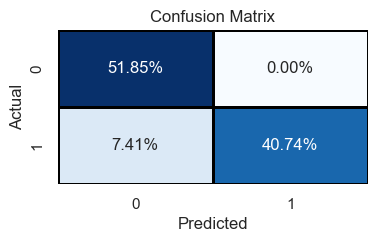

CPU times: user 109 ms, sys: 43.1 ms, total: 152 ms
Wall time: 46.9 ms


In [39]:
%%time
ypredEXP = logRes_clf.predict(xstestEXP)

_ = resultAnalysisFnx(ytestEXP.iloc[:,0].astype(int), ypredEXP, target_names=None)

### Decision Tree

In [40]:
%%time
dt_clf = DecisionTreeClassifier()
dt_clf.fit(xstrainEXP, ytrainEXP.iloc[:,0].astype(int))

CPU times: user 5.87 ms, sys: 2.17 ms, total: 8.04 ms
Wall time: 5.7 ms


DecisionTreeClassifier()

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.93      1.00      0.96        13

    accuracy                           0.96        27
   macro avg       0.96      0.96      0.96        27
weighted avg       0.97      0.96      0.96        27



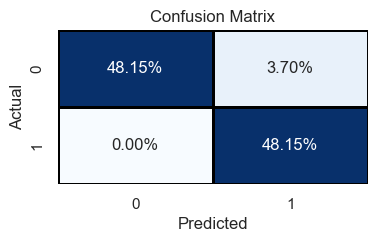

CPU times: user 106 ms, sys: 7.95 ms, total: 114 ms
Wall time: 67.7 ms


In [41]:
%%time
ypredEXP = dt_clf.predict(xstestEXP)

_ = resultAnalysisFnx(ytestEXP.iloc[:,0].astype(int), ypredEXP, target_names=None)

In [42]:
importance = dt_clf.feature_importances_
for i,j in zip(xdata.columns, importance):
    if j != 0:
        print(i, j)

LOC110530407_5 0.06374085684430508
LOC110499362_1 0.9362591431556949


In [21]:
rf_clf = RandomForestClassifier()
rf_clf.fit(xstrainEXP, ytrainEXP.iloc[:,0].astype(int))

NameError: name 'xstrainEXP' is not defined

# Experimental Section
**CAUTION:** Section is extremely experimental.

In [175]:
%%time
EXP_COLS = ['LOC110533950_2', 'LOC110522187_1']
# EXP_COLS = observedFeaturesUMD
EXP_COLS = temp_

xdataEXP, ydataEXP = dataModel.loc[:,EXP_COLS], dataModel.iloc[:,-3:-1]
# ydata.iloc[:,0] = np.array(ydata.iloc[:,0].astype(int))

sca = StandardScaler()

xdataEXP_sca = sca.fit_transform(xdataEXP)

xstrainEXP, xstestEXP, ytrainEXP, ytestEXP = train_test_split(xdataEXP_sca, ydataEXP, test_size=0.3, stratify=dataModel['strat'], random_state=SEED)

CPU times: user 9.53 ms, sys: 989 µs, total: 10.5 ms
Wall time: 10.1 ms


In [176]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xstrainEXP, ytrainEXP.iloc[:,0].astype(int))

CPU times: user 8.25 ms, sys: 4.02 ms, total: 12.3 ms
Wall time: 8.57 ms


LogisticRegression(random_state=32)

In [177]:
%%time
ypredEXP = logRes_clf.predict(xstestEXP)

CPU times: user 572 µs, sys: 24 µs, total: 596 µs
Wall time: 589 µs


              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.92      0.92      0.92        13

    accuracy                           0.93        27
   macro avg       0.93      0.93      0.93        27
weighted avg       0.93      0.93      0.93        27



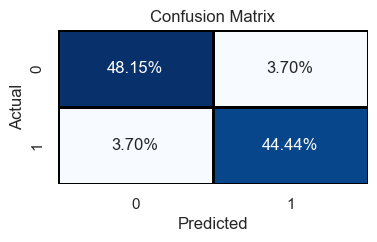

In [178]:
_ = resultAnalysisFnx(ytestEXP.iloc[:,0].astype(int), ypredEXP, target_names=None)

## Isolated Datsets

In [179]:
%%time
xtrainEXPv2, ytrainEXPv2 = dataModelUSDA.loc[:,EXP_COLS], dataModelUSDA.iloc[:,-2]

xtestEXPv2, ytestEXPv2 = dataModelUMD.loc[:,EXP_COLS], dataModelUMD.iloc[:,-2]

xtrainEXPv2, ytrainEXPv2 = shuffle(xtrainEXPv2, ytrainEXPv2, random_state=SEED)
xtestEXPv2, ytestEXPv2 = shuffle(xtestEXPv2, ytestEXPv2 , random_state=SEED)

sca = StandardScaler()

xtrainEXPv2_sca = sca.fit_transform(xtrainEXPv2)
xtestEXPv2_sca = sca.transform(xtestEXPv2)

CPU times: user 10.4 ms, sys: 3.26 ms, total: 13.7 ms
Wall time: 10.6 ms


In [180]:
# dataModelUSDA

In [181]:
%%time
logRes_clf = LogisticRegression(random_state=SEED)
logRes_clf.fit(xtrainEXPv2_sca, ytrainEXPv2.astype(int))

CPU times: user 7.43 ms, sys: 2.37 ms, total: 9.8 ms
Wall time: 7.75 ms


LogisticRegression(random_state=32)

In [182]:
%%time
ypredEXPv2 = logRes_clf.predict(xtestEXPv2)

CPU times: user 2.66 ms, sys: 39 µs, total: 2.7 ms
Wall time: 2.69 ms


              precision    recall  f1-score   support

           0       0.49      0.97      0.65        36
           1       0.00      0.00      0.00        36

    accuracy                           0.49        72
   macro avg       0.25      0.49      0.33        72
weighted avg       0.25      0.49      0.33        72



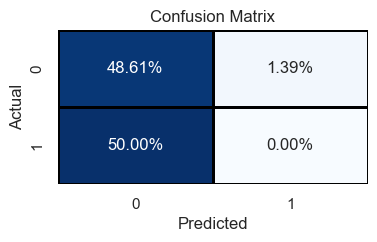

In [183]:
_ = resultAnalysisFnx(ytestEXPv2.astype(int), ypredEXPv2, target_names=None)

              precision    recall  f1-score   support

           0       1.00      0.36      0.53        36
           1       0.61      1.00      0.76        36

    accuracy                           0.68        72
   macro avg       0.81      0.68      0.64        72
weighted avg       0.81      0.68      0.64        72



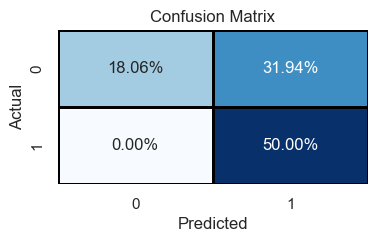

CPU times: user 135 ms, sys: 5.4 ms, total: 141 ms
Wall time: 111 ms


In [184]:
%%time
rf_clf = RandomForestClassifier()
rf_clf.fit(xtrainEXPv2_sca, ytrainEXPv2.astype(int))

ypredEXPv2 = rf_clf.predict(xtestEXPv2)
_ = resultAnalysisFnx(ytestEXPv2.astype(int), ypredEXPv2, target_names=None)

## Statstical Variation

In [153]:
dataModelExp_temp = dataModel[EXP_COLS+['tank', 'src']]

In [55]:
# # transcript = 'LOC110522187_1'
# # transcript = 'LOC110533950_2'

# plt.figure(figsize=(8,5), dpi = 80)
# sns.histplot(data = dataModelExp_temp, x=transcript, hue='src', binwidth=2)
# plt.show()

In [56]:
# plt.figure(figsize=(8,5), dpi = 80)
# sns.boxplot(data = dataModelExp_temp, y=transcript, hue='src', orient='h')
# plt.show()

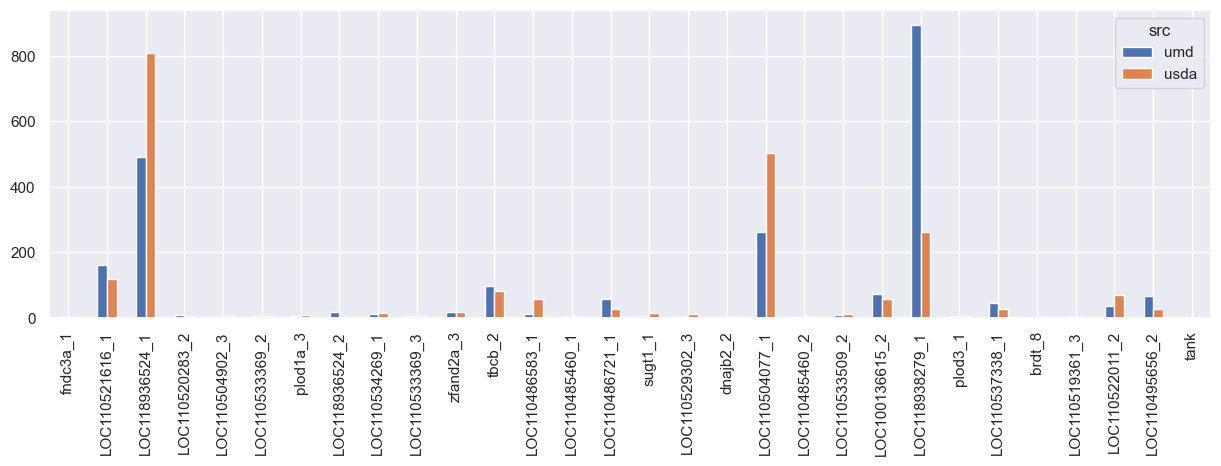

In [195]:
flag_ = dataModelExp_temp.groupby('src').mean().T
flag_.plot(kind='bar', figsize=(15, 4))
plt.title()
plt.show()

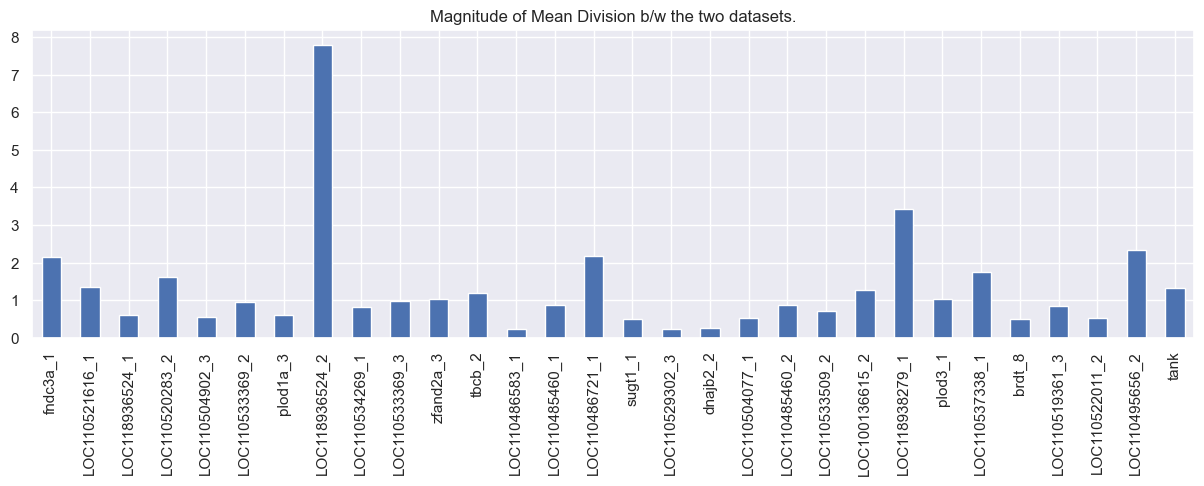

In [200]:
(flag_['umd']/flag_['usda']).plot(kind='bar', figsize=(15, 4))
plt.title("Magnitude of Mean Division b/w the two datasets.")
plt.show()

---

# Singleton Dataset - UMD

In [ ]:
%%time
dataPath = './data/TPM_stress_RedTrout.xlsx'

# data = pd.read_excel(dataPath, nrows = 100)
dataUMD = pd.read_excel(dataPath)

colsTemp = ['idx']+['CTRL']*(dataUMD.shape[1]//2)+['HEAT']*(dataUMD.shape[1]//2)

dataUMD.columns = colsTemp
dataUMD.iloc[0,0] = 'DAY'

dataUMD = dataUMD.set_index("idx").T.reset_index(drop=False, names = 'GeneExp')#.set_index("DAY", append=True)
dataUMD.rename(columns={'GeneExp':'Group'}, inplace=True)
print(dataUMD.shape)